In [1]:
import os
import tomllib
from functools import partial
from pprint import pprint
from random import randint

import matplotlib.pyplot as plt
import PIL
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from util import *

In [2]:
with open('parameters.toml', 'r') as f:
    parameters = tomllib.loads(f.read())
    
pprint(parameters)

{'TRAINING': {'batch_size': 32,
              'diseased_skin_path': './dataset/diseased/',
              'healthy_skin_path': './dataset/healthy/',
              'num_workers': 4,
              'pin_memory': True,
              'precision_threshold': 0.9,
              'shuffle': True,
              'training_dataset_ratio': 0.8}}


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
training_ratio = parameters['TRAINING']['training_dataset_ratio']
validation_ratio = testing_ratio = round(1 - round((1 + training_ratio) / 2, 1), 1)

print(f'Training ratio: {training_ratio*100}%')
print(f'Validation ratio: {validation_ratio*100}%')
print(f'Testing ratio: {testing_ratio*100}%')

seed = randint(0, 1000)
print(f'\nSeed: {seed}')


Training ratio: 80.0%
Validation ratio: 10.0%
Testing ratio: 10.0%

Seed: 248


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

criterion = nn.BCELoss().to(device)

loader_kwargs = {'batch_size': 32, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

base_dataset = SkinDiseaseDataset(root_dir='dataset', transform=transform)
train_dataset, validate_dataset, test_dataset = split_datasets(base_dataset, training_ratio, validation_ratio, testing_ratio, seed)

train_loader = DataLoader(train_dataset, **loader_kwargs)
validate_loader = DataLoader(validate_dataset, **loader_kwargs)
test_loader = DataLoader(test_dataset, **loader_kwargs)

train_cnn = partial(train_model, criterion=criterion, device=device)

print(f"Total dataset: {len(base_dataset)} items.\n")
print(f"Training: {len(train_dataset)} items.")
print(f"Validation: {len(validate_dataset)} items.")
print(f"Testing: {len(test_dataset)} items.")

Total dataset: 11039 items.

Training: 8831 items.
Validation: 1103 items.
Testing: 1103 items.


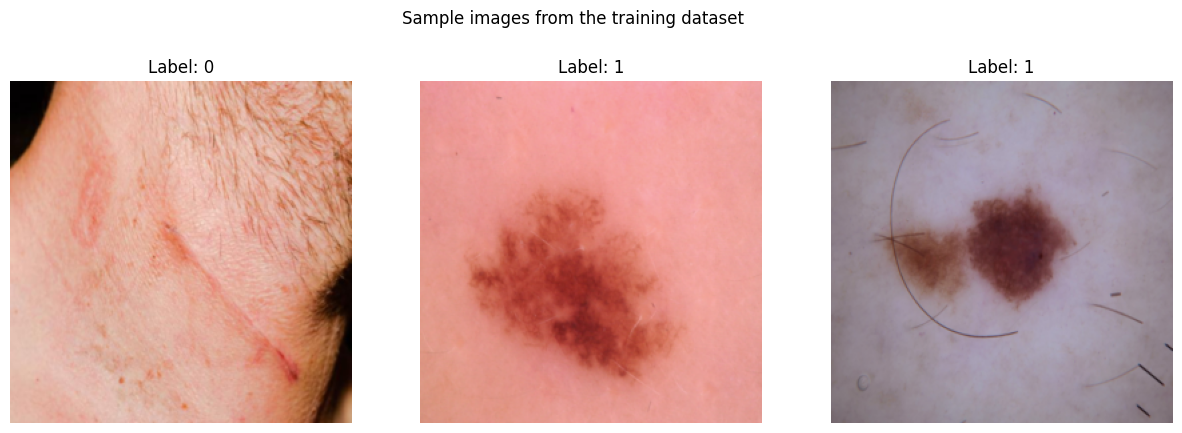

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Sample images from the training dataset')

for i, (image, label) in enumerate(train_loader):
    ax[i].imshow(image[0].permute(1, 2, 0))
    ax[i].set_title(f'Label: {label[0]}')
    ax[i].axis('off')
    if i == 2:
        break

plt.show()

## Model 1: Images with no pre-processing

In [8]:
model = BinaryCNN().to(device)
optimizer = optim.Adam(model.parameters())

train_cnn(model=model, optimizer=optimizer, data_loader=train_loader)

Epoch 1, Loss: 39.008472410948485
Epoch 2, Loss: 0.1127980803595046
Epoch 3, Loss: 0.07970703871114233
Epoch 4, Loss: 0.06649405111354587
Epoch 5, Loss: 0.05843413230457741
Epoch 6, Loss: 0.05451415960535245
Epoch 7, Loss: 0.044532027727931876
Epoch 8, Loss: 0.03672554563182411
Epoch 9, Loss: 0.031126917364852725
Epoch 10, Loss: 0.03781230231719667
